In [156]:
# -*-coding:utf-8-*-
%matplotlib inline
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARMA
import sys
from dateutil.relativedelta import relativedelta
from copy import deepcopy
#import matplotlib.pyplot as plt
import MySQLdb
import datetime
from math import isnan

windowSize = 7
forecastnum = 10

In [157]:
# 打开数据库连接
db = MySQLdb.connect("test-dataverse-web.ccxsyvw76h8l.rds.cn-north-1.amazonaws.com.cn","datauser","ebOUeWSin3hAAKKD","dataverse" )
# 使用cursor()方法获取操作游标 
cursor = db.cursor()
# 使用execute方法执行SQL语句
cursor.execute("INSERT INTO ROI_Retained_Predict_GroupBy_c (`date`, retain_day, pdtid, country_iso, channel_category, pid, retain) select date,retain_day,pdtid,country_iso,channel_category,pid,retain from (select date,retain_day,pdtid,country_iso,channel_category,pid,sum(retain) as retain from ROI_Retained group by date,retain_day,pdtid,country_iso,channel_category,pid) t on DUPLICATE KEY UPDATE retain=t.retain;")
cursor.execute("commit;")
cursor.execute("SELECT * from ROI_Retained_Predict_GroupBy_c where retain>0 and date = 20161001;")
#and date=20161024 and pdtid='600007'
data = cursor.fetchall()
#print data

In [158]:
from statsmodels.tsa.arima_model import ARIMA

#定阶
def definePQ(data):
    c = 1
    #一般阶数不超过length/10
    pmax = int(len(data)/10)
    #一般阶数不超过length/10
    qmax = int(len(data)/10)
    
    data=data.astype('float64')
    #bic矩阵
    bic_matrix = [] 
    for p in range(pmax+1):
        tmp = [] #tmp保存的是计算的bic值
        for q in range(qmax+1):#存在部分报错，所以用try来跳过报错。
            try: 
                r = ARIMA(data, (p,1,q)).fit().bic
                if isnan(r):
                    tmp.append(p+q+1000000000)
                else:
                    tmp.append(r)
            except:
                #如果bic值为None，则保存一个最大的整数来代表bic
                tmp.append(p+q+1000000000)
        print tmp
        bic_matrix.append(tmp)
    #从中可以找出最小值
    bic_matrix = pd.DataFrame(bic_matrix) 
    #先用stack展平，然后用idxmin找出最小值位置。
    p,q = bic_matrix.stack().idxmin() 
    bicMin = bic_matrix.stack()[p,q]
    if bicMin >= 1000000000:
        return 0, 0, 0 
    print(u'BIC最小的p值和q值为：%s、%s' %(p,q)) 
    return p, c, q

In [159]:
#建立ARIMA(p, c, q)模型
def buildARIMA(data, start, end):
    p,c,q = definePQ(data)
    model = ARIMA(data, (p,c,q)).fit()
    
    if c == 0:
        result = model.predict(start=start, end=end)
    else:
        result = model.predict(start=start, end=end, typ='levels')
    result = np.exp(result)
    print result
    return result

In [160]:
dic={}
#(20161001L, 20161002L, '600004', 'VN', 'adwords', 'ha_holaverse_int', 95L, None)
for i in range(len(data)):
    key=str(data[i][0]) + '#' + str(data[i][2]) + '#' + str(data[i][3]) + '#' + str(data[i][4]) + '#' + str(data[i][5])
    if dic.has_key(key):
        dic[key].extend([[data[i][1],data[i][6]]])
    else:
        dic[key]=[[data[i][1],data[i][6]]]
#print dic

In [161]:
#result

def formatTime(strs):
    strs = str(strs)
    return strs[0:4] + '-' + strs[4:6] + '-' + strs[6:8]

colname = ['cnt']
for key in dic:
    print key
    keys = key.split("#")
    indexs = []
    cnt = []
    value = dic[key]
    value.sort()
    for j in range(len(value)):
        indexs.append(value[j][0])
        cnt.append(value[j][1])
        
    ts = pd.DataFrame(cnt, index=indexs, columns=colname)
    ts['day'] = ts.index
    ts.index = pd.to_datetime(ts['day'].apply(formatTime))
    data = np.log(ts['cnt'])
    length = len(data)
    print length
    td = data.index[-1]-data.index[0]
    td = (td / np.timedelta64(1, 'D')).astype(int) + 1
    if td<>length:
        continue
    if length>5:
        resultValues = []
        datats = data
        #print datats
        newDate = datats.index[-1] + relativedelta(days=1)
        endData = datats.index[-1] + relativedelta(days=forecastnum)
        newDateStr = newDate.strftime("%Y-%m-%d")
        endDataStr = endData.strftime("%Y-%m-%d")
        #print datats #a=ARIMA(datats, (0,0,0)).fit() #print a.predict(start='2016-11-03',end='2016-11-03')
        result = buildARIMA(datats,newDateStr,endDataStr)
        sql = "INSERT INTO ROI_Retained_Predict_GroupBy_c (`date`, retain_day, pdtid, country_iso, \
            channel_category, pid, retain_predict) VALUES (%s,%s,%s,%s,%s,%s,%s) \
            ON DUPLICATE KEY UPDATE retain_predict=%s;"
        for i in range(forecastnum):
            dateStr = (newDate + relativedelta(days=i)).strftime("%Y-%m-%d").replace("-","")
            resultValues = [keys[0], dateStr, keys[1], keys[2], keys[3], keys[4], result[i], result[i]]
            cursor.execute(sql, resultValues)

        

20161001#600004#VN#adwords#ha_holaverse_int
40
[-25.199463944063062, -23.721746732375152, -24.189611223231044, -20.857726935146708, -17.457713845240562]
[-22.28286125247044, -21.870376821106579, -18.368686625684639, 1000000004, 1000000005]
[-23.217275503335561, -18.248184365306265, -16.763111975307851, 1000000005, 1000000006]
[-19.923592867935334, -16.879345391464113, -13.547105095753086, 1000000006, 1000000007]
[-16.358375785402444, -13.315399332994748, -10.560672286937184, -8.3367466888016395, 1000000008]
BIC最小的p值和q值为：0、0
2016-11-11    18.231873
2016-11-12    17.494800
2016-11-13    16.787525
2016-11-14    16.108844
2016-11-15    15.457600
2016-11-16    14.832684
2016-11-17    14.233033
2016-11-18    13.657624
2016-11-19    13.105477
2016-11-20    12.575652
Freq: D, dtype: float64
20161111
['20161001', '20161111', '600004', 'VN', 'adwords', 'ha_holaverse_int', 18.231873252832049, 18.231873252832049]
20161112
['20161001', '20161112', '600004', 'VN', 'adwords', 'ha_holaverse_int', 17.4

In [163]:
cursor.execute("commit;")
# 关闭数据库连接
db.close()

InterfaceError: (0, '')

In [86]:
logPath ="/Users/holazhai/Documents/workspace/readshift/result_uniq_sort_ha_holaverse_int_ts.log"
windowSize = 7
forecastnum = 5

In [63]:
def dfSplit(line):
    return line.split('#')[1]

In [65]:
colname = ['visitDay', 'cnt']
df = pd.read_table(logPath,sep=' ',names=colname,encoding='utf-8')
df['vDay']=df['visitDay'].apply(dfSplit)

df.index=df['vDay']
df.index = pd.to_datetime(df['vDay'])
ts = df['cnt']
data = ts['2016-08':'2016-09']
data

vDay
2016-08-01    404
2016-08-02    370
2016-08-03    332
2016-08-04    305
2016-08-05    330
2016-08-06    331
2016-08-07    310
2016-08-08    353
2016-08-09    285
2016-08-10    279
2016-08-11    269
2016-08-12    305
2016-08-13    323
2016-08-14    293
2016-08-15    291
2016-08-16    287
2016-08-17    280
2016-08-18    290
2016-08-19    271
2016-08-20    277
2016-08-21    181
2016-08-22    240
2016-08-23    252
2016-08-24    161
2016-08-25    231
2016-08-26    238
2016-08-27    224
2016-08-28    151
2016-08-29    232
2016-08-30    216
             ... 
2016-09-01    216
2016-09-02    159
2016-09-03    124
2016-09-04    124
2016-09-05    186
2016-09-06    170
2016-09-07    147
2016-09-08    180
2016-09-09    182
2016-09-10    105
2016-09-11    110
2016-09-12    160
2016-09-13    163
2016-09-14    157
2016-09-15    157
2016-09-16    159
2016-09-17    163
2016-09-18    150
2016-09-19    158
2016-09-20    130
2016-09-21    147
2016-09-22    147
2016-09-23    127
2016-09-24    144
2016-

In [66]:
#  数据预处理，两个步骤，一是log，二是差分。可保证数列的平稳性。还是用log吧
data = np.log(data)
#dataDiff = data.diff(1)

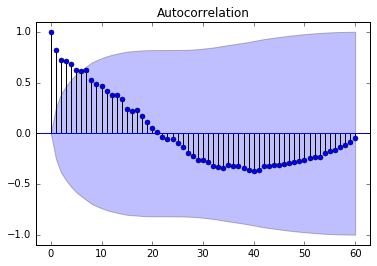

In [67]:
#自相关图
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data).show()

In [68]:
#平稳性检测
from statsmodels.tsa.stattools import adfuller as ADF
print(u'ADF Result:', ADF(data))

(u'ADF Result:', (-0.91554255607376278, 0.78281094972133336, 6, 54, {'5%': -2.9167703434435808, '1%': -3.5577091157343901, '10%': -2.59622219478738}, -31.331973984337623))


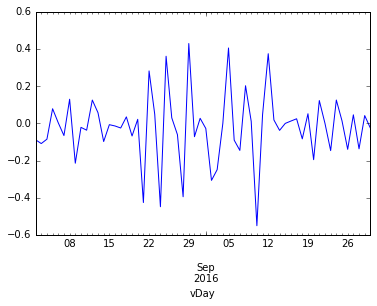

In [69]:
D_data = data.diff().dropna()
D_data.columns = [u'销量差分']
D_data.plot() 
plt.show()

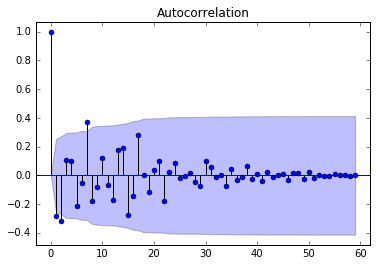

In [70]:
plot_acf(D_data).show() 

plt.show()

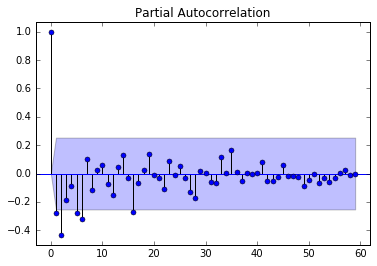

In [71]:
from statsmodels.graphics.tsaplots import plot_pacf
#偏自相关图

plot_pacf(D_data).show() 

In [72]:
print(u'ADF', ADF(D_data)) 

(u'ADF', (-6.1748054734538664, 6.6704322870264708e-08, 5, 54, {'5%': -2.9167703434435808, '1%': -3.5577091157343901, '10%': -2.59622219478738}, -31.024684264541023))


In [73]:
#白噪声检验
from statsmodels.stats.diagnostic import acorr_ljungbox
#返回统计量和p值

print(u'baizaosheng', acorr_ljungbox(D_data, lags=1)) 
#P值小于0.05，所以一阶差分后的序列为平稳非白噪声序列

(u'baizaosheng', (array([ 4.93564055]), array([ 0.02630831])))


In [74]:
from statsmodels.tsa.arima_model import ARIMA

#定阶
def definePQ(data):
    #一般阶数不超过length/10
    pmax = int(len(D_data)/10)
    #一般阶数不超过length/10
    qmax = int(len(D_data)/10) 
    data=data.astype('float64')
    #bic矩阵
    bic_matrix = [] 
    for p in range(pmax+1):
        tmp = []
        for q in range(qmax+1):#存在部分报错，所以用try来跳过报错。
            try: 
                tmp.append(ARIMA(data, (p,1,q)).fit().bic)
            except:
                tmp.append(None)
        bic_matrix.append(tmp)
    
    #从中可以找出最小值
    bic_matrix = pd.DataFrame(bic_matrix) 

    #先用stack展平，然后用idxmin找出最小值位置。
    p,q = bic_matrix.stack().idxmin() 

    print(u'BIC最小的p值和q值为：%s、%s' %(p,q)) 
    return p,q

In [78]:
print type(data)
p,q = definePQ(data)
model = ARIMA(data, (p,1,q)).fit()
start='2016-10-01'
end='2016-10-02'
result = model.predict(start=start,end=end,typ='levels')
result = np.exp(result)

print result


<class 'pandas.core.series.Series'>


ValueError: attempt to get argmin of an empty sequence

In [44]:
print ts['2016-10'].head(5)

vDay
2016-10-01    126
2016-10-02    112
2016-10-03    119
2016-10-04    111
2016-10-05    114
Name: cnt, dtype: int64
